In [114]:
# %load siamese_network_fine_tuning.py
#!/usr/bin/env python

import os, sys
sys.path.append("/scratch/xp2042/Frag20/sPhysNet-MT/")

from Networks.PhysDimeNet import PhysDimeNet
from utils.utils_functions import fix_model_keys
from torch.nn import Module
from torch.optim.swa_utils import AveragedModel


import numpy as np
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from ase.units import Hartree, eV, kcal
from scipy.spatial import Voronoi
from torch_geometric.data import Data
from tqdm import tqdm
import os.path as osp
import os
import pandas as pd
from openbabel import pybel


hartree2ev = Hartree / eV

_force_cpu = False

ev2hartree = eV / Hartree


def get_coords(pmol):
    coords = []
    for atom in pmol.atoms:
        coords.append(atom.coords)
    return np.array(coords)

def get_elements(pmol):
    z = []
    for atom in pmol.atoms:
        z.append(atom.atomicnum)
    return np.array(z)


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# def get_device():
#     return torch.device("cpu")

def set_force_cpu():
    """
    ONLY use it when pre-processing data
    :return:
    """
    global _force_cpu
    _force_cpu = True


def _get_index_from_matrix(num, previous_num):
    """
    get the fully-connect graph edge index compatible with torch_geometric message passing module
    eg: when num = 3, will return:
    [[0, 0, 0, 1, 1, 1, 2, 2, 2]
    [0, 1, 2, 0, 1, 2, 0, 1, 2]]
    :param num:
    :param previous_num: the result will be added previous_num to fit the batch
    :return:
    """
    index = torch.LongTensor(2, num * num)
    index[0, :] = torch.cat([torch.zeros(num).long().fill_(i) for i in range(num)], dim=0)
    index[1, :] = torch.cat([torch.arange(num).long() for __ in range(num)], dim=0)
    mask = (index[0, :] != index[1, :])
    return index[:, mask] + previous_num


def cal_edge(R, N, prev_N, edge_index, cal_coulomb=True, short_range=True):
    """
    calculate edge distance from edge_index;
    if cal_coulomb is True, additional edge will be calculated without any restriction
    :param short_range:
    :param cal_coulomb:
    :param prev_N:
    :param edge_index:
    :param R:
    :param N:
    :return:
    """
    if cal_coulomb:
        '''
        IMPORTANT: DO NOT use num(tensor) itself as input, which will be regarded as dictionary key in this function,
        use int value(num.item())
        Using tensor as dictionary key will cause unexpected problem, for example, memory leak
        '''
        coulomb_index = torch.cat(
            [_get_index_from_matrix(num.item(), previous_num) for num, previous_num in zip(N, prev_N)], dim=-1)
        points1 = R[coulomb_index[0, :], :]
        points2 = R[coulomb_index[1, :], :]
        coulomb_dist = torch.sum((points1 - points2) ** 2, keepdim=True, dim=-1)
        coulomb_dist = torch.sqrt(coulomb_dist)

    else:
        coulomb_dist = None
        coulomb_index = None

    if short_range:
        short_range_index = edge_index
        points1 = R[edge_index[0, :], :]
        points2 = R[edge_index[1, :], :]
        short_range_dist = torch.sum((points1 - points2) ** 2, keepdim=True, dim=-1)
        short_range_dist = torch.sqrt(short_range_dist)
    else:
        short_range_dist, short_range_index = None, None
    return coulomb_dist, coulomb_index, short_range_dist, short_range_index


def scale_R(R):
    abs_min = torch.abs(R).min()
    while abs_min < 1e-3:
        R = R - 1
        abs_min = torch.abs(R).min()
    return R


def cal_msg_edge_index(edge_index):
    msg_id_1 = torch.arange(edge_index.shape[-1]).repeat(edge_index.shape[-1], 1)
    msg_id_0 = msg_id_1.t()
    source_atom = edge_index[0, :].repeat(edge_index.shape[-1], 1)
    target_atom = edge_index[1, :].view(-1, 1)
    msg_map = (source_atom == target_atom)
    result = torch.cat([msg_id_0[msg_map].view(1, -1), msg_id_1[msg_map].view(1, -1)], dim=0)
    return result


def voronoi_edge_index(R, boundary_factor, use_center):
    """
    Calculate Voronoi Diagram
    :param R: shape[-1, 3], the location of input points
    :param boundary_factor: Manually setup a boundary for those points to avoid potential error, value of [1.1, inf]
    :param use_center: If true, the boundary will be centered on center of points; otherwise, boundary will be centered
    on [0., 0., 0.]
    :return: calculated edge idx_name
    """
    R = scale_R(R)

    R_center = R.mean(dim=0) if use_center else torch.DoubleTensor([0, 0, 0])

    # maximum relative coordinate
    max_coordinate = torch.abs(R - R_center).max()
    boundary = max_coordinate * boundary_factor
    appended_R = torch.zeros(8, 3).double().fill_(boundary)
    idx = 0
    for x_sign in [-1, 1]:
        for y_sign in [-1, 1]:
            for z_sign in [-1, 1]:
                appended_R[idx] *= torch.DoubleTensor([x_sign, y_sign, z_sign])
                idx += 1
    num_atoms = R.shape[0]

    appended_R = appended_R + R_center
    diagram = Voronoi(torch.cat([R, appended_R], dim=0), qhull_options="Qbb Qc Qz")
    edge_one_way = diagram.ridge_points
    edge_index_all = torch.LongTensor(np.concatenate([edge_one_way, edge_one_way[:, [1, 0]]], axis=0)).t()
    mask0 = edge_index_all[0, :] < num_atoms
    mask1 = edge_index_all[1, :] < num_atoms
    mask = mask0 & mask1
    edge_index = edge_index_all[:, mask]

    return edge_index


def sort_edge(edge_index):
    """
    sort the target of edge to be sequential, which may increase computational efficiency later on when training
    :param edge_index:
    :return:
    """
    arg_sort = torch.argsort(edge_index[1, :])
    return edge_index[:, arg_sort]


def mol_to_edge_index(mol):
    """
    Calculate edge_index(bonding edge) from rdkit.mol
    :param mol:
    :return:
    """
    bonds = mol.GetBonds()
    num_bonds = len(bonds)
    _edge_index = torch.zeros(2, num_bonds).long()
    for bond_id, bond in enumerate(bonds):
        _edge_index[0, bond_id] = bond.GetBeginAtomIdx()
        _edge_index[1, bond_id] = bond.GetEndAtomIdx()
    _edge_index_inv = _edge_index[[1, 0], :]
    _edge_index = torch.cat([_edge_index, _edge_index_inv], dim=-1)
    return _edge_index


def remove_bonding_edge(all_edge_index, bond_edge_index):
    """
    Remove bonding idx_name from atom_edge_index to avoid double counting
    :param all_edge_index:
    :param bond_edge_index:
    :return:
    """
    mask = torch.zeros(all_edge_index.shape[-1]).bool().fill_(False).type(all_edge_index.type())
    len_bonding = bond_edge_index.shape[-1]
    for i in range(len_bonding):
        same_atom = (all_edge_index == bond_edge_index[:, i].view(-1, 1))
        mask += (same_atom[0] & same_atom[1])
    remain_mask = ~ mask
    return all_edge_index[:, remain_mask]


def extend_bond(edge_index):
    """
    extend bond edge to a next degree, i.e. consider all 1,3 interaction as bond
    :param edge_index:
    :return:
    """
    n_edge = edge_index.size(-1)
    source = edge_index[0]
    target = edge_index[1]

    # expand into a n*n matrix
    source_expand = source.repeat(n_edge, 1)
    target_t = target.view(-1, 1)

    mask = (source_expand == target_t)
    target_index_mapper = edge_index[1].repeat(n_edge, 1)
    source_index_mapper = edge_index[0].repeat(n_edge, 1).t()

    source_index = source_index_mapper[mask]
    target_index = target_index_mapper[mask]

    extended_bond = torch.cat([source_index.view(1, -1), target_index.view(1, -1)], dim=0)
    # remove self to self interaction
    extended_bond = extended_bond[:, source_index != target_index]
    extended_bond = remove_bonding_edge(extended_bond, edge_index)
    result = torch.cat([edge_index, extended_bond], dim=-1)

    result = torch.unique(result, dim=1)
    return result


def name_extender(name, cal_3body_term=None, edge_version=None, cutoff=None, boundary_factor=None, use_center=None,
                  bond_atom_sep=None, record_long_range=False, type_3_body='B', extended_bond=False, no_ext=False,
                  geometry='QM'):
    if extended_bond:
        type_3_body = type_3_body + 'Ext'
    name += '-' + type_3_body
    if cal_3body_term:
        name += 'msg'

    if edge_version == 'cutoff':
        if cutoff is None:
            print('cutoff canot be None when edge version == cutoff, exiting...')
            exit(-1)
        name += '-cutoff-{:.2f}'.format(cutoff)
    elif edge_version == 'voronoi':
        name += '-box-{:.2f}'.format(boundary_factor)
        if use_center:
            name += '-centered'
    else:
        raise ValueError('Cannot recognize edge version(neither cutoff or voronoi), got {}'.format(edge_version))

    if sort_edge:
        name += '-sorted'

    if bond_atom_sep:
        name += '-defined_edge'

    if record_long_range:
        name += '-lr'

    name += '-{}'.format(geometry)

    if not no_ext:
        name += '.pt'
    return name


sol_keys = ["gasEnergy", "watEnergy", "octEnergy", "CalcSol", "CalcOct", "calcLogP"]


def my_pre_transform(data, edge_version, do_sort_edge, cal_efg, cutoff, boundary_factor, use_center, mol,
                     cal_3body_term, bond_atom_sep, record_long_range, type_3_body='B', extended_bond=False):
    """
    edge calculation
    atom_edge_index is non-bonding edge idx_name when bond_atom_sep=True; Otherwise, it is bonding and non-bonding together
    """
    edge_index = torch.zeros(2, 0).long()
    dist, full_edge, _, _ = cal_edge(data.pos, [data.N], [0], edge_index, cal_coulomb=True, short_range=False)
    dist = dist.cpu()
    full_edge = full_edge.cpu()

    if edge_version == 'cutoff':
        data.BN_edge_index = full_edge[:, (dist < cutoff).view(-1)]
    else:
        data.BN_edge_index = voronoi_edge_index(data.pos, boundary_factor, use_center=use_center)

    if record_long_range:
        data.L_edge_index = remove_bonding_edge(full_edge, data.BN_edge_index)

    '''
    sort edge idx_name
    '''
    if do_sort_edge:
        data.BN_edge_index = sort_edge(data.BN_edge_index)

    '''
    EFGs edge calculation
    '''
    if cal_efg:
        if edge_version == 'cutoff':
            dist, full_edge, _, _ = cal_edge(data.EFG_R, [data.EFG_N], [0], edge_index, cal_coulomb=True)
            data.EFG_edge_index = full_edge[:, (dist < cutoff).view(-1)].cpu()
        else:
            data.EFG_edge_index = voronoi_edge_index(data.EFG_R, boundary_factor, use_center=use_center)

        data.num_efg_edges = torch.LongTensor([data.EFG_edge_index.shape[-1]]).view(-1)

    if bond_atom_sep:
        '''
        Calculate bonding edges and remove those non-bonding edges which overlap with bonding edge
        '''
        if mol is None:
            print('rdkit mol file not given for molecule: {}, cannot calculate bonding edge, skipping this'.format(
                data.Z))
            return None
        B_edge_index = mol_to_edge_index(mol)
        if B_edge_index.numel() > 0 and B_edge_index.max() + 1 > data.N:
            raise ValueError('problematic mol file: {}'.format(mol))
        if B_edge_index.numel() > 0 and extended_bond:
            B_edge_index = extend_bond(B_edge_index)
        if B_edge_index.numel() > 0 and do_sort_edge:
            B_edge_index = sort_edge(B_edge_index)
        data.B_edge_index = B_edge_index
        try:
            data.N_edge_index = remove_bonding_edge(data.BN_edge_index, B_edge_index)
        except Exception as e:
            print("*"*40)
            print("BN: ", data.BN_edge_index)
            print("B: ", data.B_edge_index)
            from rdkit.Chem import MolToSmiles
            print("SMILES: ", MolToSmiles(mol))
            raise e
        _edge_list = []
        for bond_type in type_3_body:
            _edge_list.append(getattr(data, bond_type + "_edge_index"))
        _edge_index = torch.cat(_edge_list, dim=-1)
    else:
        _edge_index = data.BN_edge_index

    '''
    Calculate 3-atom term(Angle info)
    It ls essentially an "edge" of edge
    '''
    if cal_3body_term:

        atom_msg_edge_index = cal_msg_edge_index(_edge_index)
        if do_sort_edge:
            atom_msg_edge_index = sort_edge(atom_msg_edge_index)

        setattr(data, type_3_body + '_msg_edge_index', atom_msg_edge_index)

        setattr(data, 'num_' + type_3_body + '_msg_edge', torch.zeros(1).long() + atom_msg_edge_index.shape[-1])

    for bond_type in ['B', 'N', 'L', 'BN']:
        _edge_index = getattr(data, bond_type + '_edge_index', False)
        if _edge_index is not False:
            setattr(data, 'num_' + bond_type + '_edge', torch.zeros(1).long() + _edge_index.shape[-1])

    return data


# ref = np.load("../../frag20-data/atomref.B3LYP_631Gd.10As.npz")["atom_ref"]

def get_ref_energy(elements, ref):
    return np.sum([ref[z][1] for z in elements]) * ev2hartree

def extract_mol_by_confId(mol, confId):
    mol_block = Chem.MolToMolBlock(mol, confId=confId)
    mol = Chem.MolFromMolBlock(mol_block, removeHs=False)
    return mol

def generate_confs(smi, numConfs=1):
    mol = Chem.MolFromSmiles(smi)
    mol = AllChem.AddHs(mol)
    # cids = AllChem.EmbedMultipleConfs(mol, numConfs=128, maxAttempts=1000, numThreads=8)
    
    ps = AllChem.ETKDG()
    ps.maxAttempts = 1000
    ps.randomSeed = 1
    ps.pruneRmsThresh = 0.1
    ps.numThreads = 0
    cids = AllChem.EmbedMultipleConfs(mol, numConfs, ps)
    
    confs = []
    for cid in cids:
        mol_conf = extract_mol_by_confId(mol, cid)
        confs.append(mol_conf)
    return confs

def optimize(mol):
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94')
    ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=0)
    ff.Initialize()
    ff.Minimize(maxIts=1000)
    E = ff.CalcEnergy()
    return E

def get_low_energy_conf(smi, num_confs):
    mol_confs = generate_confs(smi, num_confs)
    data = []
    for m in mol_confs:
        E = optimize(m)
        data.append([E, m])
    sdata = sorted(data, key=lambda x: x[0])
    low_energy, opt_conf = sdata[0]
    mol_block = Chem.MolToMolBlock(opt_conf)
    # print(mol_block)
    pmol = pybel.readstring("mol", mol_block)
    return pmol


import torch.nn.functional as F
from torch import nn

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from scipy.stats import pearsonr
from rdkit import Chem
from rdkit.Chem import AllChem

In [115]:
df_train = pd.read_csv( "../clean_data/tox24_train_exclude_fragment.csv" )
df_test = pd.read_csv( "../clean_data/tox24_leaderboader_exclude_fragment.csv" )

In [ ]:
train_data,  train_dGs = [], []
for idx, smi1, dG, smi2 in df_train.itertuples():
   try:
       pmol2 = get_low_energy_conf(smi2, num_confs=50)
   except:
       continue
   coords2 = get_coords(pmol2)

   elements2 = get_elements(pmol2)

   N2 = coords2.shape[0]
   
   this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
                     Z = torch.as_tensor(elements2, dtype=torch.long),
                     N = torch.as_tensor(N2, dtype=torch.long).view(-1),
                     BN_edge_index_correct = torch.tensor([0], dtype=torch.long))

   nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
                                   cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
                                   bond_atom_sep=False, record_long_range=True)
   
 
   train_data.append(nthis_data2)
   train_dGs.append(dG)
   if idx % 10 == 0:
       print(idx)

0
10
20
40
60


In [74]:
# all_train_data =  [train_data, train_dGs]

# with open(  "train_data.pl", "wb" ) as f:
   # pickle.dump(all_train_data, f)

In [3]:
valid_data, valid_dGs = [], []
for idx, smi1, dG, smi2 in df_test.itertuples():
   try:
       pmol2 = get_low_energy_conf(smi2, num_confs=300)
   except:
    continue
   coords2 = get_coords(pmol2)

   elements2 = get_elements(pmol2)

   N2 = coords2.shape[0]
   
   this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
                     Z = torch.as_tensor(elements2, dtype=torch.long),
                     N = torch.as_tensor(N2, dtype=torch.long).view(-1),
                     BN_edge_index_correct = torch.tensor([0], dtype=torch.long))

   nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
                                   cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
                                   bond_atom_sep=False, record_long_range=True)
   
   valid_data.append(nthis_data2)
   valid_dGs.append(dG)
   if idx % 10 == 0:
       print(idx)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [117]:
import pickle

In [118]:
# all_valid_data = [valid_data, valid_dGs]

# with open( "valid_data.pl", "wb" ) as f:
#    pickle.dump(all_valid_data, f)

# with open( os.path.join(folder, "train_data.pl"), "rb" ) as f:
#     train_data1, train_data2, train_ddGs = pickle.load( f )

with open( "../valid_data.pl", "rb" ) as f:
    valid_data,  valid_ddGs = pickle.load( f )

In [119]:
class EmaAmsGrad(torch.optim.Adam):
    def __init__(self, training_model: torch.nn.Module, lr=1e-3, betas=(0.9, 0.99),
                 eps=1e-8, weight_decay=0, ema=0.999, shadow_dict=None):
        super().__init__(filter(lambda p: p.requires_grad, training_model.parameters()), lr, betas, eps, weight_decay, amsgrad=True)
        # for initialization of shadow model
        self.shadow_dict = shadow_dict
        self.ema = ema
        self.training_model = training_model

        def avg_fn(averaged_model_parameter, model_parameter, num_averaged):
            return ema * averaged_model_parameter + (1 - ema) * model_parameter

        def avg_fn_deactivated(averaged_model_parameter, model_parameter, num_averaged):
            return model_parameter

        self.deactivated = (ema < 0)
        self.shadow_model = AveragedModel(training_model, device=get_device(),
                                          avg_fn=avg_fn_deactivated if self.deactivated else avg_fn)

    def step(self, closure=None):
        # t0 = time.time()

        loss = super().step(closure)

        # t0 = record_data('AMS grad', t0)
        if self.shadow_model.n_averaged == 0 and self.shadow_dict is not None:
            self.shadow_model.module.load_state_dict(self.shadow_dict, strict=False)
            self.shadow_model.n_averaged += 1
        else:
            self.shadow_model.update_parameters(self.training_model)

        # t0 = record_data('shadow update', t0)
        return loss
        

def load_model(model_path):
    floating_type = torch.double

    net = PhysDimeNet( n_atom_embedding=95,
                         modules="P-noOut P-noOut P",
                         bonding_type="BN BN BN",
                         n_feature=160,
                         n_output=2,
                         n_dime_before_residual=1,
                         n_dime_after_residual=2,
                         n_output_dense=3,
                         n_phys_atomic_res=1,
                         n_phys_interaction_res=1,
                         n_phys_output_res=1,
                         n_bi_linear=8,
                         nh_lambda=0.01,
                         normalize=True,
                         shared_normalize_param=True,
                         activations="ssp ssp ssp",
                         restrain_non_bond_pred=True,
                         expansion_fn="(P_BN,P-noOut_BN):gaussian_64_10.0",
                         uncertainty_modify="none",
                         coulomb_charge_correct=False,
                         loss_metric="mae",
                         uni_task_ss=False,
                         lin_last=False,
                         last_lin_bias=False,
                         train_shift=True,
                         mask_z=False,
                         time_debug=False,
                         z_loss_weight=0,
                         acsf=False,
                         energy_shift=1.0,
                         energy_scale=2.0,
                         debug_mode=False,
                         action="names",
                         target_names=["gasEnergy", "waterEnergy"],
                         batch_norm=False,
                         dropout=False,
                         requires_atom_prop=False,
                         requires_atom_embedding=True,
                         pooling="sum",
                         ext_atom_features=None,
                         ext_atom_dim=0)

    # net = AveragedModel( net )
    # state_dict = torch.load(model_path, map_location=get_device())
    # net.load_state_dict(state_dict)
    # net = net.to(get_device())

    state_dict = torch.load(model_path, map_location=torch.device("cpu"))
    state_dict = fix_model_keys(state_dict)
    incompatible_keys = net.load_state_dict(state_dict=state_dict, strict=False)
    net = net.to(floating_type)
    net = net.to(get_device())
    return net


model_path = "../models/best_model.pt"
# model_path = "qm_models/models/best_model.pt"
net = load_model( model_path )

# for param in net.parameters():
#     param.requires_grad = False

# for param in net.main_module_list[1:].parameters():
#     param.requires_grad = True




def loss_fn(output, ddG):
    loss = F.l1_loss(output, ddG)
    return loss


@torch.no_grad()
def valid_fn(data_loader1, data_loader2, model):
    model.eval()

    trues, preds = [], []
    for data1, ddG in zip(data_loader1, data_loader2):
        data1 = data1.to(get_device())
        ddG = ddG.to(get_device()).view(-1, 1).double()
        
        output = model(data1)["mol_prop"][:, 1:]
        preds.extend(output.view(-1).cpu().numpy().tolist())
        trues.extend(ddG.view(-1).cpu().numpy().tolist())

    all_mae = mean_absolute_error(trues, preds)
    all_rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    Rp= pearsonr(trues, preds)[0]
    return Rp, r2, all_mae, all_rmse

In [120]:
# test_loader1 = DataLoader(test_data, batch_size=1, shuffle=False)
# test_loader2 = DataLoader(test_dGs, batch_size=1, shuffle=False)

In [121]:
from sklearn.model_selection import KFold

In [122]:
def train_step(data, ddG, model, optimizer):
    optimizer.zero_grad()
    
    data = data1.to(get_device())
    ddG = ddG.to(get_device()).view(-1, 1).double()
    output = model(data)["mol_prop"][:, 1:]
    
    loss = loss_fn(output, ddG)
    loss.backward()
    optimizer.step()
    return loss

In [123]:
def get_data_by_index(datas, indexs):
    subset = []
    for idx in indexs:
        subset.append( datas[idx] )
    return subset

In [124]:
with open( "../all_data_models/train_data_mm.pl", "rb" ) as f:
    train_valid_data, train_valid_dGs = pickle.load( f )

In [125]:
len( train_valid_data )

989

In [ ]:
all_models = []

kf = KFold(n_splits=5, shuffle=True)
midx = 0
for train_index, test_index in kf.split(X=train_valid_data):
    model_path = "models/best_model.pt"
    net = load_model( model_path )
    optimizer = EmaAmsGrad(net, weight_decay=0.001, lr=0.001, ema=0.999, shadow_dict=net.state_dict())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=100)
    # train_index = train_index.tolist()
    # test_index = test_index.tolist()
    # train_data, train_dGs = train_valid_data[train_index], train_valid_dGs[train_index]
    # valid_data, valid_dGs = train_valid_data[test_index], train_valid_dGs[test_index]
    
    train_data, train_dGs = get_data_by_index(train_valid_data, train_index), get_data_by_index(train_valid_dGs, train_index)
    valid_data, valid_dGs = get_data_by_index(train_valid_data, test_index), get_data_by_index(train_valid_dGs, test_index)
    split_data = [train_data, train_dGs, valid_data, valid_dGs]
    with open("fold{}_data.pl".format(midx), "wb") as f:
        pickle.dump( split_data, f )
    
    train_loader1 = DataLoader(train_data, batch_size=64, shuffle=False)
    train_loader2 = DataLoader(train_dGs, batch_size=64, shuffle=False)

    valid_loader1 = DataLoader(valid_data, batch_size=16, shuffle=False)
    valid_loader2 = DataLoader(valid_dGs, batch_size=16, shuffle=False)

    # val_Rp, val_r2, val_mae, val_rmse = valid_fn(valid_loader1, valid_loader2, net)
    # print( "Testing Epoch: Init, Rp: {}, R2: {}, MAE: {}, RMSE: {}\n".format(val_Rp, val_r2, val_mae, val_rmse))
    # # with open(os.path.join(folder, "training_info.txt"), "a") as f:
    # #     f.write( "Testing Epoch: Init, Rp: {}, R2: {}, MAE: {}, RMSE: {}\n".format(val_Rp, val_r2, val_mae, val_rmse))

    train_info, valid_info = [], []
    best_loss = np.inf
    for epoch in range(1000):
        net.train()
        # let all processes sync up before starting with a new epoch of training
    
        train_loss = 0.
        for data1, ddG in zip(train_loader1, train_loader2):
            loss = train_step(data1, ddG, net, optimizer)
            train_loss += loss.item() * data1.num_graphs
            
        print(epoch, train_loss / len(train_loader1.dataset))
    
        # # ---------------------- Post training steps: validation, save model, print meta ---------------- #
        
        shadow_net = optimizer.shadow_model

        train_Rp, train_r2, train_mae, train_rmse = valid_fn(train_loader1, train_loader2, shadow_net)
        val_Rp, val_r2, val_mae, val_rmse = valid_fn(valid_loader1, valid_loader2, shadow_net)
        # with open(os.path.join(folder, "training_info.txt"), "a") as f:
        #     f.write( "Testing Epoch: {}, Rp: {}, R2: {}, MAE: {}, RMSE: {}\n".format(epoch, val_Rp, val_r2, val_mae, val_rmse))
        print( "Testing Epoch: {}, Rp: {}, R2: {}, MAE: {}, RMSE: {}\n".format(epoch, val_Rp, val_r2, val_mae, val_rmse))
    
        valid_info.append(val_rmse)
        train_info.append(train_rmse)
        
        scheduler.step(val_rmse)
        
        if val_rmse < best_loss:
            best_loss = val_rmse
            best_model = shadow_net
            torch.save(shadow_net.state_dict(), 'best-pre-train_model_{}.pt'.format(midx))
            # torch.save(shadow_net.state_dict(), osp.join(run_directory, 'training_model.pt'))
            # torch.save(optimizer.state_dict(), osp.join(run_directory, 'best_model_optimizer.pt'))
            # torch.save(scheduler.state_dict(), osp.join(run_directory, "best_model_scheduler.pt"))
    # all_models.append(best_model)
    midx += 1

0 93.0151541097722
Testing Epoch: 0, Rp: -0.015195290621605467, R2: -34.405563201493194, MAE: 195.1363705879828, RMSE: 214.88931820745097

1 31.496271900017994
Testing Epoch: 1, Rp: -0.014671053737957448, R2: -34.23559615640878, MAE: 194.67458647780322, RMSE: 214.37290159337016

2 27.678344250765818
Testing Epoch: 2, Rp: -0.014026228226088025, R2: -34.03679115549464, MAE: 194.1320063139704, RMSE: 213.76728263489412

3 27.227077118744496
Testing Epoch: 3, Rp: -0.013302453681120886, R2: -33.81225433301975, MAE: 193.5165487677318, RMSE: 213.0812070379901

4 25.480255576114097
Testing Epoch: 4, Rp: -0.012480265027575925, R2: -33.56836906166036, MAE: 192.84469049701886, RMSE: 212.33350042482553

5 24.506004321450867
Testing Epoch: 5, Rp: -0.011546390115982892, R2: -33.30675336323745, MAE: 192.11988120762464, RMSE: 211.5284974811696

6 23.252251518506583
Testing Epoch: 6, Rp: -0.010510513051855155, R2: -33.025538166911964, MAE: 191.3371623092145, RMSE: 210.6597555400811

7 22.473709647923908

In [15]:
# train_info

In [126]:
import matplotlib.pyplot as plt

In [127]:
# with open( "train_data.pl", "rb" ) as f:
#     train_valid_data, train_valid_dGs = pickle.load( f )

with open( "../valid_data.pl", "rb" ) as f:
    test_data, test_dGs = pickle.load( f )

# Predict Ensemble

In [128]:
# ! ls

In [129]:
# model_paths = ["best_model_0.pt", "best_model_1.pt", "best_model_2.pt", "best_model_3.pt", "best_model_4.pt"]

# model_paths = ["../all_data_models/best_model_0.pt", "../all_data_models/best_model_1.pt", 
#                "../all_data_models/best_model_2.pt", "../all_data_models/best_model_3.pt", 
#                "../all_data_models/best_model_4.pt"]

# model_paths = ["all_data_train_10_times/best_model_fold0_k6.pt", "all_data_train_10_times/best_model_fold1_k9.pt", 
#                "all_data_train_10_times/best_model_fold2_k5.pt", "all_data_train_10_times/best_model_fold3_k5.pt", 
#                "all_data_train_10_times/best_model_fold4_k4.pt"]
import glob

# model_paths =  glob.glob("all_data_train_10_times/best_model_fold*_k*.pt")

# model_paths = ["best_model_fold0_k3.pt", "best_model_fold1_k2.pt", 
#                "best_model_fold2_k6.pt", "best_model_fold3_k1.pt", 
#                "best_model_fold4_k3.pt"]

# model_paths =  glob.glob("best-fine-tune_model_v2.pt")

model_paths = glob.glob("*.pt")


models = []
for model_path in model_paths:
    net = load_model( model_path )
    net = net.eval()
    models.append( net )

In [130]:
len(models)

10

In [131]:
model_paths

['best_model_fold5_k0.pt',
 'best_model_fold2_k0.pt',
 'best_model_fold6_k0.pt',
 'best_model_fold4_k0.pt',
 'best_model_fold1_k0.pt',
 'best_model_fold3_k0.pt',
 'best_model_fold9_k0.pt',
 'best_model_fold0_k0.pt',
 'best_model_fold8_k0.pt',
 'best_model_fold7_k0.pt']

In [132]:
@torch.no_grad()
def predict_ensemble(data_loader1, data_loader2, models):
    trues, preds, stds = [], [], []
    for data1, ddG in zip(data_loader1, data_loader2):
        data1 = data1.to(get_device())
        ddG = ddG.to(get_device()).view(-1, 1).double()

        multiple_preds = []
        for model in models:
            # model.eval()
            output = model(data1)["mol_prop"][:, 1:]
            multiple_preds.append(output.view(-1).cpu().item())
        preds.append(np.mean(multiple_preds))
        stds.append(np.std(multiple_preds))
        trues.append(ddG.item())
    return preds, trues, stds


@torch.no_grad()
def predict_ensemble_single(data1, models):
    # print(data1)
    pred, std = [], []
    data1 = data1.to(get_device())
   
    multiple_preds = []
    for model in models:
        model.eval()
        output = model(data1)["mol_prop"][:, 1:]
        multiple_preds.append(output.view(-1).cpu().item())
    return multiple_preds

In [133]:
df_test = pd.read_csv( "../manuscript/tox24_test_exclude_fragment.csv" )

In [134]:
df_test.head()

,SMILES,TTR binding activity,cSMILES
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,70.6,Cc1cc(Cl)ccc1OC(C)C(=O)O
1,CC(C)=CCC/C(/C)=C/CO,49.0,CC(C)=CCC/C(C)=C/CO
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,40.4,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1
3,COC1=CC=C(/C=C/C)C=C1,25.4,C/C=C/c1ccc(OC)cc1
4,CC(C)=CCC/C(/C)=C\CO,84.9,CC(C)=CCC/C(C)=C\CO


In [135]:
len(df_test)

300

In [136]:
len( models )

10

In [137]:
df_test.head()

,SMILES,TTR binding activity,cSMILES
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,70.6,Cc1cc(Cl)ccc1OC(C)C(=O)O
1,CC(C)=CCC/C(/C)=C/CO,49.0,CC(C)=CCC/C(C)=C/CO
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,40.4,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1
3,COC1=CC=C(/C=C/C)C=C1,25.4,C/C=C/c1ccc(OC)cc1
4,CC(C)=CCC/C(/C)=C\CO,84.9,CC(C)=CCC/C(C)=C\CO


In [38]:
preds = []
for idx, smi1, dG, smi2 in df_test.itertuples():
    try:
        pmol2 = get_low_energy_conf(smi2, num_confs=100)
    except:
        preds.append( [None, None, None, None, None] ) 
        continue
        
    coords2 = get_coords(pmol2)
    elements2 = get_elements(pmol2)
    
    N2 = coords2.shape[0]
    
    this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
                     Z = torch.as_tensor(elements2, dtype=torch.long),
                     N = torch.as_tensor(N2, dtype=torch.long).view(-1),
                     BN_edge_index_correct = torch.tensor([0], dtype=torch.long),
                     batch=torch.tensor([0 for i in range(N2)], dtype=torch.long))
    
    nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
                                   cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
                                   bond_atom_sep=False, record_long_range=True)

    multi_pred = predict_ensemble_single( nthis_data2, models )
    preds.append( multi_pred ) 
    if idx % 10 == 0:
        print( idx )

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210


[11:02:54] UFFTYPER: Warning: hybridization set to SP for atom 0
[11:02:54] UFFTYPER: Unrecognized charge state for atom: 0


220
230
240
250
260


[11:05:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1


270
280


In [42]:
all_data = []
for idx, smi, exp, csmi in df_test.itertuples():
    all_data.append([smi, csmi, exp] + preds[idx])

dfn_test = pd.DataFrame(all_data)
dfn_test.columns = ["SMILES", "cSMILES", "TTR binding activity", "pred_0", "pred_1", "pred_2", "pred_3", "pred_4"]

In [43]:
len(dfn_test)

300

In [44]:
dfn_test.head()

,SMILES,cSMILES,TTR binding activity,pred_0,pred_1,pred_2,pred_3,pred_4
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,Cc1cc(Cl)ccc1OC(C)C(=O)O,70.6,63.921407,81.048403,66.872989,56.859021,70.192200
1,CC(C)=CCC/C(/C)=C/CO,CC(C)=CCC/C(C)=C/CO,49.0,40.257118,25.872626,32.655569,28.772761,40.272489
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,40.4,11.224487,14.834931,6.505278,12.637063,9.597457
3,COC1=CC=C(/C=C/C)C=C1,C/C=C/c1ccc(OC)cc1,25.4,14.548781,22.980487,18.445192,18.652681,19.788078
4,CC(C)=CCC/C(/C)=C\CO,CC(C)=CCC/C(C)=C\CO,84.9,39.901501,23.050851,31.275997,35.895185,49.853639


In [46]:
# dfn_test.to_csv("tox24_test_Xiaolin.csv", sep=",", index=None)

In [171]:
pmols = pybel.readfile("sdf", "leaderboard_noconf_mmff.sdf")

In [172]:
for pmol in pmols:
    coords2 = get_coords(pmol2)
    elements2 = get_elements(pmol2)
    
    N2 = coords2.shape[0]
    
    this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
                     Z = torch.as_tensor(elements2, dtype=torch.long),
                     N = torch.as_tensor(N2, dtype=torch.long).view(-1),
                     BN_edge_index_correct = torch.tensor([0], dtype=torch.long),
                     batch=torch.tensor([0 for i in range(N2)], dtype=torch.long))
    
    nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
                                   cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
                                   bond_atom_sep=False, record_long_range=True)

    multi_pred = predict_ensemble_single( nthis_data2, models )
    print(",".join([str(round(i, 4)) for i in mulit_pred]))

14.4665,17.5333,13.8834,32.242,10.4147
14.4665,17.5333,13.8834,32.242,10.4147


In [70]:
pmols = pybel.readfile("sdf", "test_set_noconf.sdf")

In [71]:
for pmol in pmols:
    print(pmol.title)
    coords2 = get_coords(pmol)
    elements2 = get_elements(pmol)
    
    N2 = coords2.shape[0]
    
    this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
                     Z = torch.as_tensor(elements2, dtype=torch.long),
                     N = torch.as_tensor(N2, dtype=torch.long).view(-1),
                     BN_edge_index_correct = torch.tensor([0], dtype=torch.long),
                     batch=torch.tensor([0 for i in range(N2)], dtype=torch.long))
    
    nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
                                   cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
                                   bond_atom_sep=False, record_long_range=True)

    multi_pred = predict_ensemble_single( nthis_data2, models )
    print(",".join([str(round(i, 4)) for i in multi_pred]))

Structure11
2.3424,0.4196,5.3445,13.8614,0.2733
Structure12
21.3523,26.4367,23.8712,24.5765,26.5265


# Get WeiJun Results

In [174]:
df_all = pd.read_csv("KANO_tox24_test_pred_121824.csv")

In [175]:
df_all.head()

,cSMILES,F_1_M_0,F_1_M_1,F_1_M_2,F_1_M_3,F_1_M_4,F_2_M_0,F_2_M_1,F_2_M_2,F_2_M_3,...,F_3_M_1,F_3_M_2,F_3_M_3,F_3_M_4,F_4_M_0,F_4_M_1,F_4_M_2,F_4_M_3,F_4_M_4,emb
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,11.976676,10.354269,17.395539,16.187471,11.918152,7.407439,4.733034,13.181309,16.084200,...,8.664836,11.953255,17.069065,11.869889,8.652147,3.557343,8.771479,8.890007,14.686324,11.245331
1,Cc1cc(Cl)ccc1OC(C)C(=O)O,61.600414,69.987682,56.084533,44.226861,52.009709,55.250753,50.978495,66.762196,50.630174,...,62.618580,69.970148,53.190772,63.520917,58.268307,53.362460,59.801929,53.983522,58.805710,57.863815
2,CC(C)=CCC/C(C)=C/CO,49.577302,40.594493,51.938889,37.776900,32.321430,44.615977,36.409386,66.356630,54.292210,...,76.545205,39.896567,49.565035,53.665505,53.267300,41.564444,51.652647,48.972617,47.260463,48.376480
3,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,9.911071,16.390834,13.378837,21.176473,11.706255,15.401751,11.732329,6.715174,12.057941,...,8.713893,7.790501,12.254784,5.155701,14.391704,11.183780,16.027534,7.491304,11.264241,12.093274
4,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,76.591420,86.870209,59.822530,70.318146,69.054906,15.533815,14.234963,9.071600,24.519705,...,17.706021,44.420116,36.529763,21.553620,25.551581,16.404231,15.393322,21.147750,18.185482,35.109250


In [176]:
df_leaderboard = pd.read_csv("KANO_tox24_leaderboard_pred_121824.csv")

In [177]:
df_leaderboard.head()

,cSMILES,TTR binding activity,F_1_M_0,F_1_M_1,F_1_M_2,F_1_M_3,F_1_M_4,F_2_M_0,F_2_M_1,F_2_M_2,...,F_3_M_1,F_3_M_2,F_3_M_3,F_3_M_4,F_4_M_0,F_4_M_1,F_4_M_2,F_4_M_3,F_4_M_4,emb
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,11.695433,11.975427,10.337692,17.396512,16.188013,11.918440,7.409877,4.740691,13.181880,...,8.663740,11.955381,17.066513,11.867459,8.652596,3.554231,8.767823,8.889195,14.688150,11.244231
1,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,13.585867,76.581531,86.869060,59.834273,70.310998,69.065861,15.555157,14.281109,9.067375,...,17.721353,44.369899,36.529079,21.562010,25.551721,16.405094,15.302034,21.223393,18.137830,35.106209
2,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(=O)O,88.580711,80.722568,76.034385,87.117697,78.310340,74.100081,75.727523,77.212582,95.178683,...,90.095536,67.156367,74.287388,74.546093,79.404205,77.928217,81.524264,65.010913,75.883853,79.262564
3,Cl/C=C/Cl,3.066265,5.168432,5.935531,5.821516,10.783680,8.259905,8.677979,6.133481,5.437540,...,10.305148,14.423249,12.644619,22.004964,4.263843,1.367118,4.552503,14.153542,13.797429,9.106933
4,Nc1c(Cl)cc([N+](=O)[O-])cc1Cl,99.778579,103.337610,98.731481,99.980865,94.288092,98.273231,97.477540,100.463660,97.480899,...,106.487341,101.383584,95.851672,98.817930,89.831703,102.951257,96.999091,95.433381,105.707212,98.599375


In [178]:
df_test = df_all[~df_all["cSMILES"].isin(df_leaderboard["cSMILES"].tolist())]

In [179]:
len(df_test)

300

In [180]:
df_test.head()

,cSMILES,F_1_M_0,F_1_M_1,F_1_M_2,F_1_M_3,F_1_M_4,F_2_M_0,F_2_M_1,F_2_M_2,F_2_M_3,...,F_3_M_1,F_3_M_2,F_3_M_3,F_3_M_4,F_4_M_0,F_4_M_1,F_4_M_2,F_4_M_3,F_4_M_4,emb
1,Cc1cc(Cl)ccc1OC(C)C(=O)O,61.600414,69.987682,56.084533,44.226861,52.009709,55.250753,50.978495,66.762196,50.630174,...,62.618580,69.970148,53.190772,63.520917,58.268307,53.362460,59.801929,53.983522,58.805710,57.863815
2,CC(C)=CCC/C(C)=C/CO,49.577302,40.594493,51.938889,37.776900,32.321430,44.615977,36.409386,66.356630,54.292210,...,76.545205,39.896567,49.565035,53.665505,53.267300,41.564444,51.652647,48.972617,47.260463,48.376480
3,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,9.911071,16.390834,13.378837,21.176473,11.706255,15.401751,11.732329,6.715174,12.057941,...,8.713893,7.790501,12.254784,5.155701,14.391704,11.183780,16.027534,7.491304,11.264241,12.093274
7,C/C=C/c1ccc(OC)cc1,39.101153,47.875621,39.827733,35.713835,43.641321,29.103323,25.337872,30.007856,34.316478,...,39.269407,45.426686,40.824266,40.693160,35.965013,41.520230,44.045034,43.149685,50.622603,38.640846
8,CC(C)=CCC/C(C)=C\CO,48.393820,39.655724,49.821597,37.828445,31.530039,43.961101,35.632586,65.693963,53.654055,...,76.427273,39.436956,48.823755,52.890116,52.527408,41.172430,51.216012,48.154427,46.278453,47.750390


In [181]:
# df_test.iloc[211, :]

In [182]:
dfo_test = pd.read_csv("../manuscript/tox24_test_exclude_fragment.csv")

In [183]:
dfo_test.head()

,SMILES,TTR binding activity,cSMILES
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,70.6,Cc1cc(Cl)ccc1OC(C)C(=O)O
1,CC(C)=CCC/C(/C)=C/CO,49.0,CC(C)=CCC/C(C)=C/CO
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,40.4,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1
3,COC1=CC=C(/C=C/C)C=C1,25.4,C/C=C/c1ccc(OC)cc1
4,CC(C)=CCC/C(/C)=C\CO,84.9,CC(C)=CCC/C(C)=C\CO


In [184]:
csmi = 'CCCCCCCCCCCCOS(O)(=O)=O'

In [185]:
df_test[df_test["cSMILES"].isin( [csmi] )]

,cSMILES,F_1_M_0,F_1_M_1,F_1_M_2,F_1_M_3,F_1_M_4,F_2_M_0,F_2_M_1,F_2_M_2,F_2_M_3,...,F_3_M_1,F_3_M_2,F_3_M_3,F_3_M_4,F_4_M_0,F_4_M_1,F_4_M_2,F_4_M_3,F_4_M_4,emb
285,CCCCCCCCCCCCOS(O)(=O)=O,53.510149,65.051676,47.365598,57.215524,47.014263,47.493351,45.47064,63.201892,56.254351,...,70.321253,53.853838,55.675561,50.463318,65.994805,56.3739,56.018439,40.059672,45.901343,55.431081


In [186]:
len(df_test)

300

In [187]:
all_data = []
for idx, smi, exp, csmi in dfo_test.itertuples():
    # print(idx, csmi)
    preds = df_test[df_test["cSMILES"] == csmi].iloc[0, 1:].tolist()
    all_data.append( [smi, csmi, exp] + preds )

In [188]:
# all_data

In [189]:
dfn_test = pd.DataFrame(all_data)
dfn_test.columns = ['SMILES', 'cSMILES', 'TTR binding activity', 'F_1_M_0', 'F_1_M_1', 'F_1_M_2', 'F_1_M_3', 'F_1_M_4', 'F_2_M_0', 'F_2_M_1', 'F_2_M_2', 'F_2_M_3', 'F_2_M_4', 'F_3_M_0', 'F_3_M_1', 'F_3_M_2', 'F_3_M_3', 'F_3_M_4', 'F_4_M_0', 'F_4_M_1', 'F_4_M_2', 'F_4_M_3', 'F_4_M_4', 'emb']

In [190]:
dfn_test.head()

,SMILES,cSMILES,TTR binding activity,F_1_M_0,F_1_M_1,F_1_M_2,F_1_M_3,F_1_M_4,F_2_M_0,F_2_M_1,...,F_3_M_1,F_3_M_2,F_3_M_3,F_3_M_4,F_4_M_0,F_4_M_1,F_4_M_2,F_4_M_3,F_4_M_4,emb
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,Cc1cc(Cl)ccc1OC(C)C(=O)O,70.6,61.600414,69.987682,56.084533,44.226861,52.009709,55.250753,50.978495,...,62.618580,69.970148,53.190772,63.520917,58.268307,53.362460,59.801929,53.983522,58.805710,57.863815
1,CC(C)=CCC/C(/C)=C/CO,CC(C)=CCC/C(C)=C/CO,49.0,49.577302,40.594493,51.938889,37.776900,32.321430,44.615977,36.409386,...,76.545205,39.896567,49.565035,53.665505,53.267300,41.564444,51.652647,48.972617,47.260463,48.376480
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,40.4,9.911071,16.390834,13.378837,21.176473,11.706255,15.401751,11.732329,...,8.713893,7.790501,12.254784,5.155701,14.391704,11.183780,16.027534,7.491304,11.264241,12.093274
3,COC1=CC=C(/C=C/C)C=C1,C/C=C/c1ccc(OC)cc1,25.4,39.101153,47.875621,39.827733,35.713835,43.641321,29.103323,25.337872,...,39.269407,45.426686,40.824266,40.693160,35.965013,41.520230,44.045034,43.149685,50.622603,38.640846
4,CC(C)=CCC/C(/C)=C\CO,CC(C)=CCC/C(C)=C\CO,84.9,48.393820,39.655724,49.821597,37.828445,31.530039,43.961101,35.632586,...,76.427273,39.436956,48.823755,52.890116,52.527408,41.172430,51.216012,48.154427,46.278453,47.750390


In [191]:
dfn_test.to_csv("tox24_test_Weijun.csv", sep=",", index=None)

In [49]:
df_test["pred"] = [i[0] if not np.isnan(i) else i for i in preds ]
df_test["std"] = [i[0] if not np.isnan(i) else i for i in stds ]

In [50]:
df_test.head()

,SMILES,TTR binding activity,cSMILES,pred,std
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,11.695433,CC1=CC[C@H]2C[C@@H]1C2(C)C,17.707972,7.610478
1,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,13.585867,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,59.152405,15.328089
2,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(O)=O,88.580711,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(=O)O,107.557473,15.658289
3,Cl/C=C/Cl,3.066265,Cl/C=C/Cl,4.529596,1.843859
4,NC1=C(Cl)C=C(C=C1Cl)[N+]([O-])=O,99.778579,Nc1c(Cl)cc([N+](=O)[O-])cc1Cl,96.083577,9.095005


In [51]:
dff_test = df_test[~df_test["pred"].isna()]

In [52]:
dff_test.head()

,SMILES,TTR binding activity,cSMILES,pred,std
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,11.695433,CC1=CC[C@H]2C[C@@H]1C2(C)C,17.707972,7.610478
1,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,13.585867,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,59.152405,15.328089
2,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(O)=O,88.580711,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(=O)O,107.557473,15.658289
3,Cl/C=C/Cl,3.066265,Cl/C=C/Cl,4.529596,1.843859
4,NC1=C(Cl)C=C(C=C1Cl)[N+]([O-])=O,99.778579,Nc1c(Cl)cc([N+](=O)[O-])cc1Cl,96.083577,9.095005


In [53]:
r2_score( dff_test["TTR binding activity"], dff_test["pred"] )

0.5634346091143723

In [54]:
pearsonr( dff_test["TTR binding activity"], dff_test["pred"] )

PearsonRResult(statistic=0.7546971811519195, pvalue=9.965644605946197e-38)

In [55]:
mean_absolute_error(dff_test["TTR binding activity"], dff_test["pred"])

15.440795049386956

In [56]:
np.sqrt(mean_squared_error(dff_test["TTR binding activity"], dff_test["pred"]))

21.94319471021491

In [37]:
# 0.7022637869446378, 17.976848779696525, 24.254783777304105
# 0.75, 15.93, 21.995

In [38]:
dff_test.head()

,SMILES,TTR binding activity,cSMILES,pred,std
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,11.695433,CC1=CC[C@H]2C[C@@H]1C2(C)C,17.707972,7.610478
1,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,13.585867,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,59.152405,15.328089
2,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(O)=O,88.580711,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(=O)O,107.557473,15.658289
3,Cl/C=C/Cl,3.066265,Cl/C=C/Cl,4.529596,1.843859
4,NC1=C(Cl)C=C(C=C1Cl)[N+]([O-])=O,99.778579,Nc1c(Cl)cc([N+](=O)[O-])cc1Cl,96.083577,9.095005


In [27]:
dff_test.sort_values( "std", ascending=False )

,SMILES,TTR binding activity,cSMILES,pred,std
140,CCCN(CCC)C1=C(C=C(C=C1[N+]([O-])=O)C(C)C)[N+](...,82.156261,CCCN(CCC)c1c([N+](=O)[O-])cc(C(C)C)cc1[N+](=O)...,75.948800,21.476204
174,[Na+].CCCOC1=NN(C(=O)[N-]S(=O)(=O)C2=C(C=CC=C2...,52.288918,CCCOc1nn(C(=O)[N-]S(=O)(=O)c2ccccc2C(=O)OC)c(=...,52.405245,20.438533
75,[Na+].COC1=CC=C(C=C1)N=NC2=C(OC)C=C(N=NC3=CC=C...,111.121880,COc1ccc(N=Nc2cc(C)c(N=Nc3ccc(S(=O)(=O)[O-])cc3...,103.223132,19.363394
172,CCCN(CCC)C1=C(C(N)=C(C=C1[N+]([O-])=O)C(F)(F)F...,106.598353,CCCN(CCC)c1c([N+](=O)[O-])cc(C(F)(F)F)c(N)c1[N...,79.463057,18.409906
199,FC1(F)/C(=C\C(=O)N2CCC(N3CCCCC3)CC2)/C=4C(N(CC...,-3.819957,Cc1occc1C(=O)Nc1ccc(C(=O)N2CCC(F)(F)/C(=C\C(=O...,47.902730,18.380743
...,...,...,...,...,...
108,CNC,2.714484,CNC,3.399841,1.774048
10,ClCC(Cl)CCl,10.700795,ClCC(Cl)CCl,7.954004,1.712609
62,C=CCN=C=S,11.238935,C=CCN=C=S,17.704181,1.694321
89,NC#N,3.603488,N#CN,2.924667,1.604964


In [57]:
len(models)

5

In [58]:
# preds, trues, stds = [], [], []
# for idx, smi1, dG, smi2 in df_train.itertuples():
#     try:
#         pmol2 = get_low_energy_conf(smi2, num_confs=50)
#     except:
#         preds.append( np.nan ) 
#         trues.append( dG )
#         stds.append( np.nan )
#         continue
        
#     coords2 = get_coords(pmol2)
#     elements2 = get_elements(pmol2)
    
#     N2 = coords2.shape[0]
    
#     this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
#                      Z = torch.as_tensor(elements2, dtype=torch.long),
#                      N = torch.as_tensor(N2, dtype=torch.long).view(-1),
#                      BN_edge_index_correct = torch.tensor([0], dtype=torch.long),
#                      batch=torch.tensor([0 for i in range(N2)], dtype=torch.long))
    
#     nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
#                                    cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
#                                    bond_atom_sep=False, record_long_range=True)
#     # print(nthis_data2)
#     pred, std = predict_ensemble_single( nthis_data2, models )
#     preds.append( pred ) 
#     trues.append( dG )
#     stds.append( std )
#     if idx % 10 == 0:
#         print( idx )

In [31]:
# df_train["pred"] = [i[0] if not np.isnan(i) else i for i in preds ]
# df_train["std"] = [i[0] if not np.isnan(i) else i for i in stds ]

In [59]:
# dfs_train = df_train.sort_values("std", ascending=False)

In [60]:
# dfs_train.head()

In [61]:
# dfs_train = pd.read_csv("clean_data/train_std.csv")

In [62]:
# len(dfs_train)

In [63]:
# dfs_train["error"] = dfs_train["activity"] - dfs_train["pred"]
# dfs_train["error"] = abs(dfs_train["error"])

In [64]:
# dfs_train.iloc[:100, :]

In [65]:
# mols2grid.display(dfs_train[:100, :], smiles_col="cSMILES", subset=["activity", "pred", "std", "error"], size=(150, 150))

In [66]:
# dfs_train.iloc[28, 2]

In [67]:
# dfs_train.to_csv("clean_data/train_std.csv")

In [68]:
# dff_train = df_train[~df_train["std"].isna()]
# dff_train = dff_train[dff_train["std"] <= 16]

In [69]:
# dff_train.head()

In [70]:
# len(dff_train)

In [71]:
# dff_train.to_csv("clean_data/train_filter.csv")

# inference

In [97]:
df_test = pd.read_csv("../manuscript/tox24_test_exclude_fragment.csv")

In [98]:
df_test.head()

,SMILES,TTR binding activity,cSMILES
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,70.6,Cc1cc(Cl)ccc1OC(C)C(=O)O
1,CC(C)=CCC/C(/C)=C/CO,49.0,CC(C)=CCC/C(C)=C/CO
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,40.4,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1
3,COC1=CC=C(/C=C/C)C=C1,25.4,C/C=C/c1ccc(OC)cc1
4,CC(C)=CCC/C(/C)=C\CO,84.9,CC(C)=CCC/C(C)=C\CO


In [99]:
len(df_test)

300

In [100]:
schrodinger_confs = []
for mol in Chem.SDMolSupplier("../submit_data/sphysnet_results/test_set_nan_comps.sdf", removeHs=False):
    schrodinger_confs.append([mol.GetProp("_Name"), mol])

df_confs = pd.DataFrame(schrodinger_confs, columns=["name", "mol"])

df_confs["pmol"] = df_confs["mol"].map( lambda x: pybel.readstring("mol", Chem.MolToMolBlock(x)))

In [101]:
df_confs.head()

,name,mol,pmol
0,CCCC[Sn](Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x155431adfa70>,CCCC[Sn](Cl)(Cl)Cl\tCCCC[Sn](Cl)(Cl)Cl\n
1,c1ccc([Hg]c2ccccc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x155431adf920>,c1ccc([Hg]c2ccccc2)cc1\tc1ccc([Hg]c2ccccc2)cc1\n
2,O=[Si]=O,<rdkit.Chem.rdchem.Mol object at 0x155431adf7d0>,O=[Si]=O\tO=[Si]=O\n
3,c1ccc(B(c2ccccc2)c2ccccc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x155431adf610>,c1ccc(B(c2ccccc2)c2ccccc2)cc1\tc1ccc(B(c2ccccc...


In [102]:
preds = []
for idx, smi, exp, csmi in df_test.itertuples():
    if csmi in ["[Hg+2]" ]:
        preds.append([None, None, None, None, None])
        continue
    try:
        pmol2 = get_low_energy_conf(csmi, num_confs=100)
    except:
        print(csmi)
        pmol2 = df_confs[df_confs["name"] == csmi].iloc[0, 2]
        # preds.append( np.nan ) 
        # stds.append( np.nan )
        # continue
    
    
    coords2 = get_coords(pmol2)
    elements2 = get_elements(pmol2)
    
    N2 = coords2.shape[0]
    
    this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
                     Z = torch.as_tensor(elements2, dtype=torch.long),
                     N = torch.as_tensor(N2, dtype=torch.long).view(-1),
                     BN_edge_index_correct = torch.tensor([0], dtype=torch.long),
                     batch=torch.tensor([0 for i in range(N2)], dtype=torch.long))
    
    nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
                                   cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
                                   bond_atom_sep=False, record_long_range=True)
  
    multi_pred = predict_ensemble_single( nthis_data2, models )
    preds.append( multi_pred ) 
    if idx % 10 == 0:
        print( idx )

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


[14:53:18] UFFTYPER: Warning: hybridization set to SP3 for atom 1


O=[Si]=O
270
280
c1ccc(B(c2ccccc2)c2ccccc2)cc1
290


In [107]:
len( df_test )

300

In [108]:
df_test.head()

,SMILES,TTR binding activity,cSMILES
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,70.6,Cc1cc(Cl)ccc1OC(C)C(=O)O
1,CC(C)=CCC/C(/C)=C/CO,49.0,CC(C)=CCC/C(C)=C/CO
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,40.4,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1
3,COC1=CC=C(/C=C/C)C=C1,25.4,C/C=C/c1ccc(OC)cc1
4,CC(C)=CCC/C(/C)=C\CO,84.9,CC(C)=CCC/C(C)=C\CO


In [109]:
# preds

In [111]:
all_data = []
for idx, smi, exp, csmi in df_test.itertuples():
    all_data.append([smi, csmi, exp] + preds[idx])

dfn_test = pd.DataFrame(all_data)
dfn_test.columns = ["SMILES", "cSMILES", "TTR binding activity", "pred_0", "pred_1", "pred_2", "pred_3", "pred_4", "pred_5", "pred_6", "pred_7", "pred_8", "pred_9"]

In [112]:
dfn_test.head()

,SMILES,cSMILES,TTR binding activity,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,Cc1cc(Cl)ccc1OC(C)C(=O)O,70.6,64.659401,64.402477,67.407893,64.835613,59.764618,60.658002,72.302240,79.668988,75.656014,74.898499
1,CC(C)=CCC/C(/C)=C/CO,CC(C)=CCC/C(C)=C/CO,49.0,33.401757,39.454955,34.431581,41.505837,76.287863,44.301440,41.255689,38.283594,47.925276,44.115647
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,40.4,27.576850,7.420067,0.474934,1.530437,4.896824,20.866010,10.419567,-8.523896,-7.299705,15.167773
3,COC1=CC=C(/C=C/C)C=C1,C/C=C/c1ccc(OC)cc1,25.4,26.005397,20.657745,28.650481,28.370068,18.183552,35.139848,45.109270,22.892111,29.514735,26.005163
4,CC(C)=CCC/C(/C)=C\CO,CC(C)=CCC/C(C)=C\CO,84.9,31.528807,31.665570,33.603792,41.299404,87.090160,33.247195,42.373345,50.588143,50.781240,42.335436


In [113]:
dfn_test.to_csv("tox24_test_Xiaolin.csv", sep=",", index=None)

In [ ]:
# dff_test = df_test[~df_test["pred"].isna()]

In [ ]:
# len( dff_test )

In [ ]:
pearsonr(df_test["TTR binding activity"], df_test["pred"])

In [ ]:
np.sqrt(mean_squared_error(df_test["TTR binding activity"], df_test["pred"]))

In [ ]:
mean_absolute_error(df_test["TTR binding activity"], df_test["pred"])

In [ ]:
# df_test.to_csv("submit_data/test_sphysnet.csv", index=None)

In [ ]:
# df_test[df_test["pred"].isna()]

In [54]:
dff = pd.read_csv("fine_tune/tox24_challenge_test.csv")

In [55]:
dff.head()

,SMILES,TTR binding activity
0,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,70.6
1,CC(C)=CCC/C(/C)=C/CO,49.0
2,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,40.4
3,COC1=CC=C(/C=C/C)C=C1,25.4
4,CC(C)=CCC/C(/C)=C\CO,84.9


In [58]:
len(dff)

300

In [56]:
dff["pred"] =  [i[0] if not np.isnan(i) else i for i in preds ]

ValueError: Length of values (500) does not match length of index (300)

In [73]:
df_test = pd.read_csv("../submit_data/sphysnet_results/test_sphysnet_addnan.csv")

In [74]:
df_kano = pd.read_csv("../submit_data/tox_24_test_KANO_prediction.csv")

In [75]:
df_kano.head()

,KANO_preds
0,12.695268
1,68.156559
2,55.351587
3,13.063408
4,61.922514


In [76]:
df_yaowen = pd.read_csv("../submit_data/Tox24_test_Ensemble_Pred_Yaowen_0831.csv")

In [77]:
df_yaowen.head()

,SMILES,Ensemble_Pred_Yaowen
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,15.219262
1,Cc1cc(Cl)ccc1OC(C)C(=O)O,69.774816
2,CC(C)=CCC/C(C)=C/CO,68.745638
3,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,8.589805
4,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,46.546932


In [78]:
df_test["kano"] = df_kano["KANO_preds"]

In [79]:
df_test["yaowen"] = df_yaowen["Ensemble_Pred_Yaowen"]

In [80]:
# df_test["pred"] = [i[0] if not np.isnan(i) else i for i in preds ]

In [81]:
all_preds = []
for idx, row in df_test.iterrows():
    spred = row.loc["pred"]
    if np.isnan(spred):
        spred = (row.loc["kano"] + row.loc["yaowen"]) / 2.0
        print(111)
    all_preds.append(spred)

111


In [82]:
df_test["pred"] = all_preds

In [83]:
df_test.head()

,SMILES,cSMILES,pred,kano,yaowen
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,CC1=CC[C@H]2C[C@@H]1C2(C)C,17.707972,12.695268,15.219262
1,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,Cc1cc(Cl)ccc1OC(C)C(=O)O,68.199880,68.156559,69.774816
2,CC(C)=CCC/C(/C)=C/CO,CC(C)=CCC/C(C)=C/CO,42.055110,55.351587,68.745638
3,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,6.880208,13.063408,8.589805
4,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,59.152405,61.922514,46.546932


In [84]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'KANO')

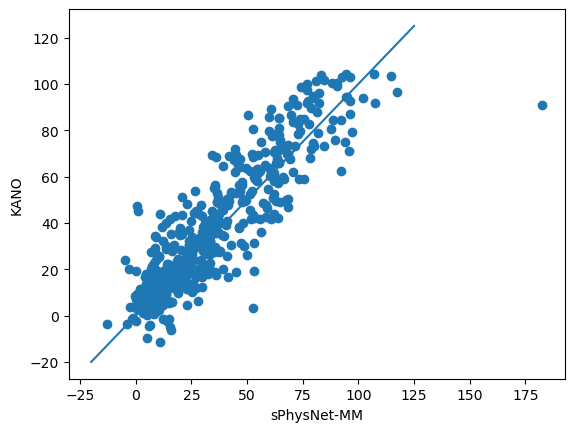

In [38]:
plt.scatter( df_test["pred"], df_test["yaowen"])
plt.plot([-20, 125], [-20, 125])
plt.xlabel("sPhysNet-MM")
plt.ylabel("KANO")

Text(0, 0.5, 'KANO')

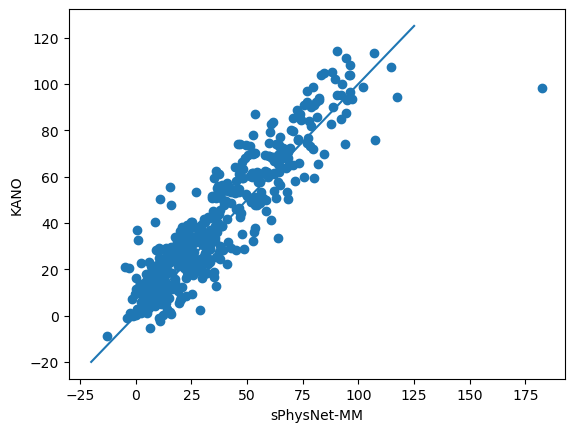

In [39]:
plt.scatter( df_test["pred"], df_test["kano"])
plt.plot([-20, 125], [-20, 125])
plt.xlabel("sPhysNet-MM")
plt.ylabel("KANO")

Text(0, 0.5, 'KANO')

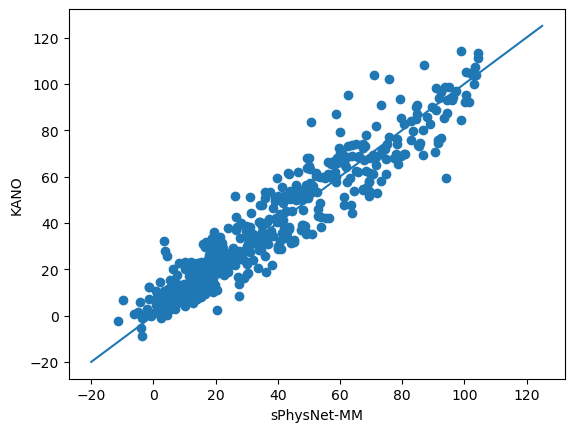

In [40]:
plt.scatter( df_test["yaowen"], df_test["kano"])
plt.plot([-20, 125], [-20, 125])
plt.xlabel("sPhysNet-MM")
plt.ylabel("KANO")

In [130]:
all_preds = []
for idx, row in df_test.iterrows():
    spred = row.loc["pred"]
    enspred = (row.loc["kano"] + row.loc["yaowen"]) / 2.0
    if abs(spred - enspred) > 50:
        print(idx)
    # all_preds.append(spred)

207


In [132]:
df_test.iloc[207, 1]

'Cc1ccc(S(=O)(=O)Oc2ccc(N=Nc3ccc(-c4ccc(N=Nc5c(O)ccc6cc(S(=O)(=O)[O-])cc(S(=O)(=O)[O-])c56)c(C)c4)cc3C)cc2)cc1'

In [133]:
df_test.head()

,SMILES,cSMILES,kano,yaowen,pred
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,CC1=CC[C@H]2C[C@@H]1C2(C)C,12.038914,12.958635,11.515446
1,CC(OC1=C(C)C=C(Cl)C=C1)C(O)=O,Cc1cc(Cl)ccc1OC(C)C(=O)O,60.473693,67.026317,67.069696
2,CC(C)=CCC/C(/C)=C/CO,CC(C)=CCC/C(C)=C/CO,60.118888,62.818829,35.425116
3,CC(CN1C[C@H](C)O[C@H](C)C1)CC2=CC=C(C=C2)C(C)(C)C,CC(Cc1ccc(C(C)(C)C)cc1)CN1C[C@@H](C)O[C@@H](C)C1,13.000207,14.013985,9.674389
4,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O,18.447844,17.676027,18.702741


In [41]:
df_test["ens"] = df_test["kano"] +  df_test["yaowen"] +  df_test["pred"]
df_test["ens"] = df_test["ens"] / 3.0

In [42]:
df_test.to_csv("submit_data/all_preds.csv", index=None)

In [43]:
df_test.iloc[:, 5:].to_csv("submit_data/submit_yingkaizhang.csv", index=None)

In [18]:
for pmol2 in pybel.readfile("sdf", "test_data/test_set.sdf"):
    coords2 = get_coords(pmol2)
    elements2 = get_elements(pmol2)
    
    N2 = coords2.shape[0]
    
    this_data2 = Data(pos = torch.as_tensor(coords2, dtype=torch.double),
                     Z = torch.as_tensor(elements2, dtype=torch.long),
                     N = torch.as_tensor(N2, dtype=torch.long).view(-1),
                     BN_edge_index_correct = torch.tensor([0], dtype=torch.long),
                     batch=torch.tensor([0 for i in range(N2)], dtype=torch.long))
    
    nthis_data2 = my_pre_transform( this_data2, edge_version="cutoff", do_sort_edge=True, cal_efg=False,
                                   cutoff=10.0, boundary_factor=100., use_center=True, mol=None, cal_3body_term=False,
                                   bond_atom_sep=False, record_long_range=True)
    # print(nthis_data2)
    pred, std = predict_ensemble_single( nthis_data2, models )
    print(pmol2.title, pred, std)
    # preds.append( pred ) 
    # stds.append( std )
    # if idx % 10 == 0:
    #     print( idx )

CCCC[Sn](Cl)(Cl)Cl [10.159320532828064] [8.223506528280591]
c1ccc([Hg]c2ccccc2)cc1 [20.38619746386405] [7.028616221319954]
O=[Si]=O [5.20411738683967] [7.399967774520991]
c1ccc(B(c2ccccc2)c2ccccc2)cc1 [15.856882579017247] [5.206638317676302]


In [264]:
df_train = pd.read_csv("clean_data/tox24_leaderboader_exclude_fragment.csv")

In [265]:
df_train.head()

,SMILES,TTR binding activity,cSMILES
0,CC1=CC[C@H]2C[C@@H]1C2(C)C,11.695433,CC1=CC[C@H]2C[C@@H]1C2(C)C
1,CC[C@H](C)[C@H](N1SC2=CC=CC=C2C1=O)C(O)=O,13.585867,CC[C@H](C)[C@@H](C(=O)O)n1sc2ccccc2c1=O
2,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(O)=O,88.580711,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(=O)O
3,Cl/C=C/Cl,3.066265,Cl/C=C/Cl
4,NC1=C(Cl)C=C(C=C1Cl)[N+]([O-])=O,99.778579,Nc1c(Cl)cc([N+](=O)[O-])cc1Cl


In [266]:
len(df_train)

200

In [267]:
sw = Chem.SDWriter("tox24_leaderboader.sdf")
for idx, smi1, dG, smi2 in df_train.itertuples():
    mol = Chem.MolFromSmiles( smi2 )
    if not mol:
        continue
    mol.SetProp("_Name", "{}".format(idx))
    mol.SetProp("_dG", "{}".format(dG))
    sw.write(mol)
sw.close()